In [1]:
!pip install imageio-ffmpeg

In [1]:
import os

print(os.getcwd()) 

/home/youngju/youngju/NeRF/NeRF_Implementations/step_1_nerf/NeRF


In [2]:
import numpy as np
import imageio
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange


# access to directory

project_path = '/home/youngju/youngju/NeRF/NeRF_Implementations/step_1_nerf/NeRF'
print(os.listdir(project_path))
os.chdir(project_path)
print(os.getcwd())

['configs', '.ipynb_checkpoints', 'Part1-NeRF.pptx', 'NeRF_practice_lecture.ipynb', '.DS_Store', 'Part1-NeRF.pdf', 'data', 'logs']
/home/youngju/youngju/NeRF/NeRF_Implementations/step_1_nerf/NeRF


### config setting

In [3]:
def config_parser():

    import argparse
    parser = argparse.ArgumentParser()

    parser.add_argument("--expname", type=str, 
                        help='experiment name')
    parser.add_argument("--basedir", type=str, default='./logs/', 
                        help='where to store ckpts and logs')
    parser.add_argument("--datadir", type=str, default='./data/llff/fern', 
                        help='input data directory')

    # training options
    parser.add_argument("--netdepth", type=int, default=8, 
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, 
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, 
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network')
    parser.add_argument("--N_rand", type=int, default=32*32*4, 
                        help='batch size (number of random rays per gradient step)')
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate')
    parser.add_argument("--lrate_decay", type=int, default=250, 
                        help='exponential learning rate decay (in 1000 steps)')
    parser.add_argument("--chunk", type=int, default=1024*32, 
                        help='number of rays processed in parallel, decrease if running out of memory')
    parser.add_argument("--netchunk", type=int, default=1024*64, 
                        help='number of pts sent through network in parallel, decrease if running out of memory')
    parser.add_argument("--no_batching", action='store_true', 
                        help='only take random rays from 1 image at a time')
    parser.add_argument("--no_reload", action='store_true', 
                        help='do not reload weights from saved ckpt')
    parser.add_argument("--ft_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network')

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64, 
                        help='number of coarse samples per ray')
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray')
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter')
    parser.add_argument("--use_viewdirs", action='store_true', 
                        help='use full 5D input instead of 3D')
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none')
    parser.add_argument("--multires", type=int, default=10, 
                        help='log2 of max freq for positional encoding (3D location)')
    parser.add_argument("--multires_views", type=int, default=4, 
                        help='log2 of max freq for positional encoding (2D direction)')
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended')

    parser.add_argument("--render_only", action='store_true', 
                        help='do not optimize, reload weights and render out render_poses path')
    parser.add_argument("--render_test", action='store_true', 
                        help='render the test set instead of render_poses path')
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview')

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops')
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops') 

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff', 
                        help='options: llff / blender / deepvoxels')
    parser.add_argument("--testskip", type=int, default=8, 
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels')

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase')

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', 
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.add_argument("--half_res", action='store_true', 
                        help='load blender synthetic data at 400x400 instead of 800x800')

    ## llff flags
    parser.add_argument("--factor", type=int, default=8, 
                        help='downsample factor for LLFF images')
    parser.add_argument("--no_ndc", action='store_true', 
                        help='do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.add_argument("--lindisp", action='store_true', 
                        help='sampling linearly in disparity rather than depth')
    parser.add_argument("--spherify", action='store_true', 
                        help='set for spherical 360 scenes')
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8')

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=100, 
                        help='frequency of console printout and metric loggin')
    parser.add_argument("--i_img",     type=int, default=500, 
                        help='frequency of tensorboard image logging')
    parser.add_argument("--i_weights", type=int, default=10000, 
                        help='frequency of weight ckpt saving')
    parser.add_argument("--i_testset", type=int, default=50000, 
                        help='frequency of testset saving')
    parser.add_argument("--i_video",   type=int, default=50000, 
                        help='frequency of render_poses video saving')

    return parser

In [4]:
parser = config_parser()
args = parser.parse_args(args=[])
args.config = 'configs/lego.txt'

# load config

with open(args.config, 'r') as fp:
    lines = fp.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split(' = ') for line in lines if len(line)>0]

configs = {}
for line in lines:
    configs[line[0]] = line[1]

print(configs)

args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']
args.no_batching = configs['no_batching']
args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.precrop_iters = int(configs['precrop_iters'])
args.precrop_frac = float(configs['precrop_frac'])
args.half_res = configs['half_res']

args.no_reload = True
print(args)


device = torch.device("cuda")
DEBUG=False
print(device)

{'expname': 'blender_paper_lego', 'basedir': './logs', 'datadir': './data/nerf_synthetic/lego', 'dataset_type': 'blender', 'no_batching': 'True', 'use_viewdirs': 'True', 'white_bkgd': 'True', 'lrate_decay': '500', 'N_samples': '64', 'N_importance': '128', 'N_rand': '1024', 'precrop_iters': '500', 'precrop_frac': '0.5', 'half_res': 'True'}
Namespace(N_importance=128, N_rand=1024, N_samples=64, basedir='./logs', chunk=32768, config='configs/lego.txt', datadir='./data/nerf_synthetic/lego', dataset_type='blender', expname='blender_paper_lego', factor=8, ft_path=None, half_res='True', i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching='True', no_ndc=False, no_reload=True, perturb=1.0, precrop_frac=0.5, precrop_iters=500, raw_noise_std=0.0, render_factor=0, render_only=False, render_

## 1-2. Blender dataset 준비 및 전처리

* Blender train/test/val data image 및 camera pose를 로드 및 numpy array로 변환
* train/test/val 데이터 인덱스 구하기
* Camera angle(FOV)를 focal length로 변환

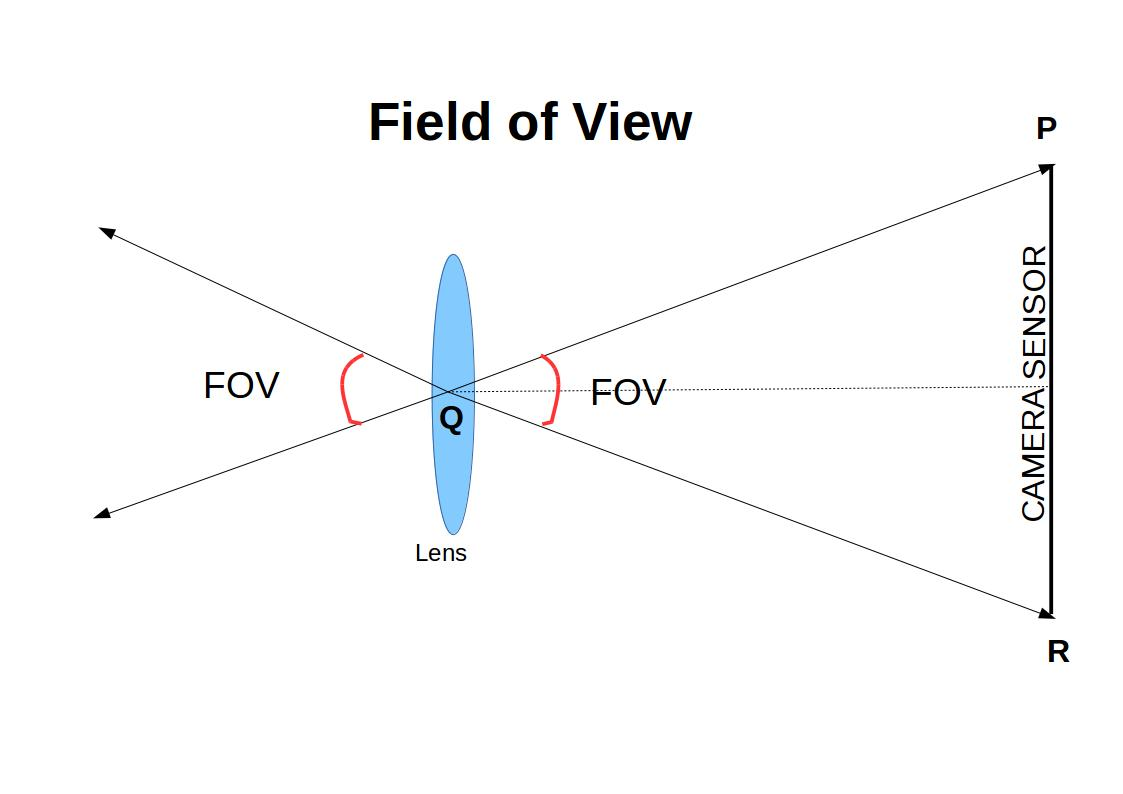

### 3D rotation matrix
#### - right thumb rule
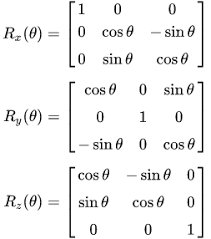

In [6]:
import os
import torch
import numpy as np
import imageio 
import json
import torch.nn.functional as F
import cv2

# translation
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

# x-axis rotation
rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

# y-axis rotation
rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


# cam2world
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w # @ denotes matrix multiplication
    c2w = rot_theta(theta/180.*np.pi) @ c2w # camera가 바라보는 방향은
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w # world 좌표계 x-axis를 반대로, y-axis & z-axis 바꾸기
    # lookat point는 보통 원점, 혹은 원점 근처. 따라서 camera 가 바라보는 방향은 camera 의 - z-axis
    return c2w

### Check and Visualize Dataset


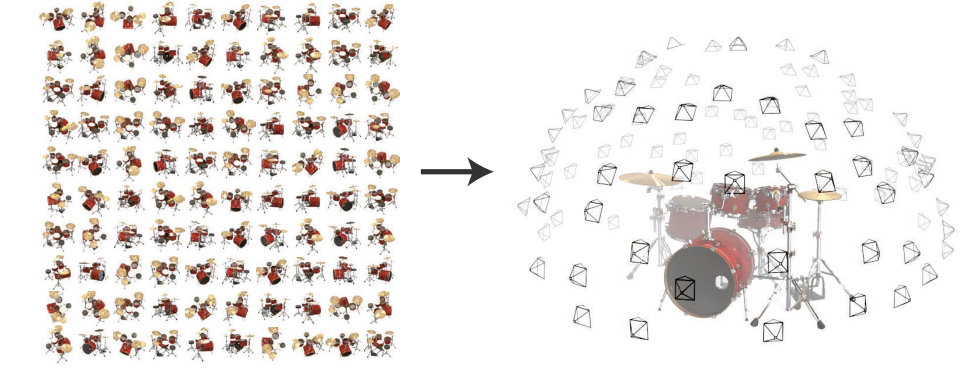

### Blender Data visualization & preprocessing
- synthetic data
- wide view

{'file_path': './test/r_0', 'rotation': 0.031415926535897934, 'transform_matrix': [[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462], [0.0, 0.0, 0.0, 1.0]]}
./data/nerf_synthetic/lego/./test/r_0.png


/tmp/ipykernel_6970/69821305.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)


(800, 800, 4)


/tmp/ipykernel_6970/69821305.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)
/tmp/ipykernel_6970/69821305.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)


(10, 800, 800, 4)


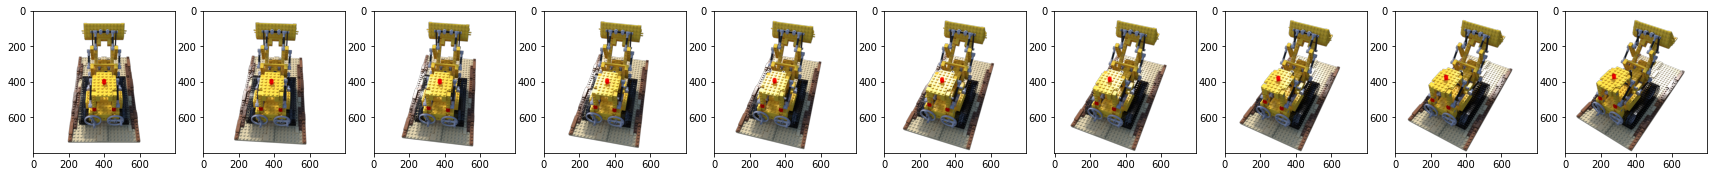

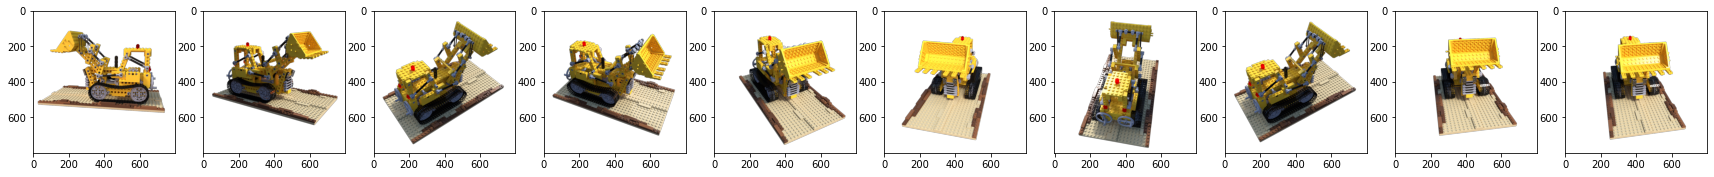

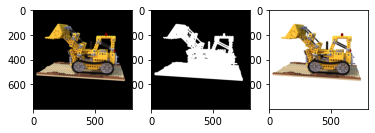

In [7]:
# data practice
_datadir = './data/nerf_synthetic/lego'
 
with open(os.path.join(_datadir, 'transforms_test.json'), 'r') as fp:
    meta = json.load(fp)

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path'] + '.png')
print(_fname)

# sample image load
img = imageio.imread(_fname)
print(img.shape) # 4 channel rgba

import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 10, figsize=(30, 300)) # 10개의 figure

for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path'] + '.png')
    img = imageio.imread(_fname)
    axis[i].imshow(img) # 해당 위치에 image visualization

# random sample visualization
import random
random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30, 300)) # 10개의 figure
imgs = []
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path'] + '.png')
    img = imageio.imread(_fname)
    imgs.append(img)
    axis[i].imshow(img) # 해당 위치에 image visualization

imgs = (np.array(imgs) / 255.).astype(np.float32)
print(imgs.shape)

imgs_orig = imgs[..., :3]
imgs_mask = imgs[..., -1]
imgs = imgs[..., :3]*imgs[..., -1:] + (1 - imgs[..., -1:]) # white backgrounds


fig, axis = plt.subplots(1, 3)
axis[0].imshow(imgs_orig[0]) # RGB 3 channels
axis[1].imshow(imgs_mask[0], cmap='gray') # grayscale
axis[2].imshow(imgs[0])

## LLFF data
- real scene data
- forward facing data
- about 20 views for each scene

['./data/nerf_llff_data/fern/images/IMG_4029.JPG',
 './data/nerf_llff_data/fern/images/IMG_4030.JPG',
 './data/nerf_llff_data/fern/images/IMG_4036.JPG',
 './data/nerf_llff_data/fern/images/IMG_4043.JPG',
 './data/nerf_llff_data/fern/images/IMG_4032.JPG']
20
(3024, 4032, 3)


/tmp/ipykernel_6970/3452145269.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(imgs[0])
/tmp/ipykernel_6970/3452145269.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)


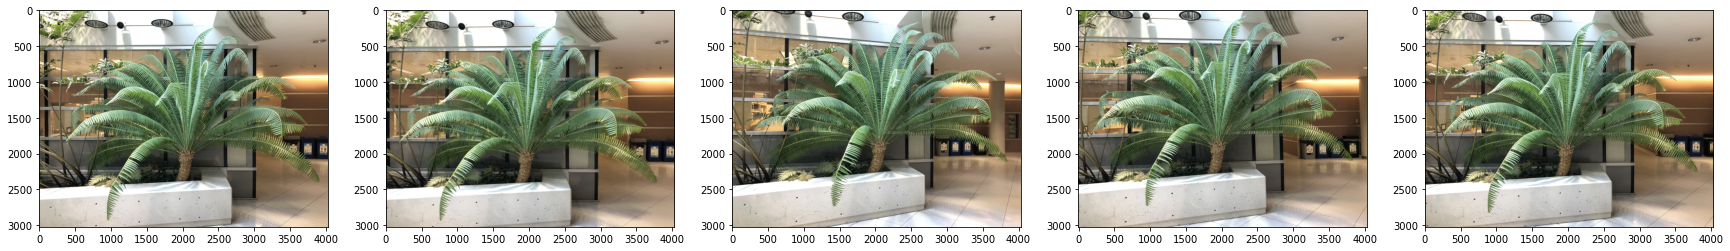

In [9]:
_datadir = './data/nerf_llff_data/fern'
imgs = [os.path.join(_datadir, 'images', f) for f in os.listdir(os.path.join(_datadir, 'images')) \
        if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
from pprint import pprint
pprint(imgs[:5])
print(len(imgs))

img = imageio.imread(imgs[0])
print(img.shape) # 3024, 4032, 3

fig, axis = plt.subplots(1, 5, figsize=(30, 600))
for i in range(5):
    _fname = imgs[i]
    img = imageio.imread(_fname)
    axis[i].imshow(img)

In [128]:
def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s=='train' or testskip==0:
            skip = 1
        else:
            skip = testskip
            
        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame['transform_matrix']))
        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0]) # start index, end of train index, end of val index, end of test index
        # counts = [0, 200, 210, 220]
        all_imgs.append(imgs)
        all_poses.append(poses)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)] # index for each split
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    
    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    
    # rendering할 pose를 미리 정의 (inference time에서 사용할 views)
    render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    
    
    # 학습 cost 줄이기 => image resize하면 focal length도 줄여주어야 한다.
    if half_res:
        H = H//2
        W = W//2
        # important - change focal
        focal = focal/2.
    

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res

        
    return imgs, poses, render_poses, [H, W, focal], i_split

In [129]:
def normalize(x):
    return x / np.linalg.norm(x)

def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m

def poses_avg(poses):

    hwf = poses[0, :3, -1:]

    center = poses[:, :3, 3].mean(0)
    vec2 = normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    c2w = np.concatenate([viewmatrix(vec2, up, center), hwf], 1)
    
    return c2w

def render_path_spiral(c2w, up, rads, focal, zdelta, zrate, rots, N):
    render_poses = []
    rads = np.array(list(rads) + [1.])
    hwf = c2w[:,4:5]
    
    for theta in np.linspace(0., 2. * np.pi * rots, N+1)[:-1]:
        c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) 
        z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.])))
        render_poses.append(np.concatenate([viewmatrix(z, up, c), hwf], 1))
    return render_poses


def recenter_poses(poses):

    poses_ = poses+0
    bottom = np.reshape([0,0,0,1.], [1,4])
    c2w = poses_avg(poses)
    c2w = np.concatenate([c2w[:3,:4], bottom], -2)
    bottom = np.tile(np.reshape(bottom, [1,1,4]), [poses.shape[0],1,1])
    poses = np.concatenate([poses[:,:3,:4], bottom], -2)

    poses = np.linalg.inv(c2w) @ poses
    poses_[:,:3,:4] = poses[:,:3,:4]
    poses = poses_
    return poses


def _minify(basedir, factors=[], resolutions=[]):
    needtoload = False
    for r in factors:
        imgdir = os.path.join(basedir, 'images_{}'.format(r))
        if not os.path.exists(imgdir):
            needtoload = True
    for r in resolutions:
        imgdir = os.path.join(basedir, 'images_{}x{}'.format(r[1], r[0]))
        if not os.path.exists(imgdir):
            needtoload = True
    if not needtoload:
        return
    
    from shutil import copy
    from subprocess import check_output
    
    imgdir = os.path.join(basedir, 'images')
    imgs = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir))]
    imgs = [f for f in imgs if any([f.endswith(ex) for ex in ['JPG', 'jpg', 'png', 'jpeg', 'PNG']])]
    imgdir_orig = imgdir
    
    wd = os.getcwd()

    for r in factors + resolutions:
        if isinstance(r, int):
            name = 'images_{}'.format(r)
            resizearg = '{}%'.format(100./r)
        else:
            name = 'images_{}x{}'.format(r[1], r[0])
            resizearg = '{}x{}'.format(r[1], r[0])
        imgdir = os.path.join(basedir, name)
        if os.path.exists(imgdir):
            continue
            
        print('Minifying', r, basedir)
        
        os.makedirs(imgdir)
        check_output('cp {}/* {}'.format(imgdir_orig, imgdir), shell=True)
        
        ext = imgs[0].split('.')[-1]
        args = ' '.join(['mogrify', '-resize', resizearg, '-format', 'png', '*.{}'.format(ext)])
        print(args)
        os.chdir(imgdir)
        check_output(args, shell=True)
        os.chdir(wd)
        
        if ext != 'png':
            check_output('rm {}/*.{}'.format(imgdir, ext), shell=True)
            print('Removed duplicates')
        print('Done')

def _load_data(basedir, factor=None, width=None, height=None, load_imgs=True):
    
    poses_arr = np.load(os.path.join(basedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    bds = poses_arr[:, -2:].transpose([1,0])
    
    img0 = [os.path.join(basedir, 'images', f) for f in sorted(os.listdir(os.path.join(basedir, 'images'))) \
            if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')][0]
    sh = imageio.imread(img0).shape
    
    sfx = ''
    
    if factor is not None:
        sfx = '_{}'.format(factor)
        _minify(basedir, factors=[factor])
        factor = factor
    elif height is not None:
        factor = sh[0] / float(height)
        width = int(sh[1] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    elif width is not None:
        factor = sh[1] / float(width)
        height = int(sh[0] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    else:
        factor = 1
    
    imgdir = os.path.join(basedir, 'images' + sfx)
    if not os.path.exists(imgdir):
        print( imgdir, 'does not exist, returning' )
        return
    
    imgfiles = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir)) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
    if poses.shape[-1] != len(imgfiles):
        print( 'Mismatch between imgs {} and poses {} !!!!'.format(len(imgfiles), poses.shape[-1]) )
        return
    
    sh = imageio.imread(imgfiles[0]).shape
    poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
    poses[2, 4, :] = poses[2, 4, :] * 1./factor
    
    if not load_imgs:
        return poses, bds
    
    def imread(f):
        if f.endswith('png'):
            return imageio.imread(f, ignoregamma=True)
        else:
            return imageio.imread(f)
        
    imgs = imgs = [imread(f)[...,:3]/255. for f in imgfiles]
    imgs = np.stack(imgs, -1)  
    
    print('Loaded image data', imgs.shape, poses[:,-1,0])
    return poses, bds, imgs


def load_llff_data(basedir, factor=8, recenter=True, bd_factor=.75, spherify=False, path_zflat=False):
    

    poses, bds, imgs = _load_data(basedir, factor=factor) # factor=8 downsamples original imgs by 8x
    print('Loaded', basedir, bds.min(), bds.max())
    
    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    imgs = np.moveaxis(imgs, -1, 0).astype(np.float32)
    images = imgs
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    
    # Rescale if bd_factor is provided
    sc = 1. if bd_factor is None else 1./(bds.min() * bd_factor)
    poses[:,:3,3] *= sc
    bds *= sc
    
    if recenter:
        poses = recenter_poses(poses)
        
    if spherify:
        poses, render_poses, bds = spherify_poses(poses, bds)

    else:
        
        c2w = poses_avg(poses)
        print('recentered', c2w.shape)
        print(c2w[:3,:4])

        ## Get spiral
        # Get average pose
        up = normalize(poses[:, :3, 1].sum(0))

        # Find a reasonable "focus depth" for this dataset
        close_depth, inf_depth = bds.min()*.9, bds.max()*5.
        dt = .75
        mean_dz = 1./(((1.-dt)/close_depth + dt/inf_depth))
        focal = mean_dz

        # Get radii for spiral path
        shrink_factor = .8
        zdelta = close_depth * .2
        tt = poses[:,:3,3] # ptstocam(poses[:3,3,:].T, c2w).T
        rads = np.percentile(np.abs(tt), 90, 0)
        c2w_path = c2w
        N_views = 120
        N_rots = 2
        if path_zflat:
#             zloc = np.percentile(tt, 10, 0)[2]
            zloc = -close_depth * .1
            c2w_path[:3,3] = c2w_path[:3,3] + zloc * c2w_path[:3,2]
            rads[2] = 0.
            N_rots = 1
            N_views/=2

        # Generate poses for spiral path
        render_poses = render_path_spiral(c2w_path, up, rads, focal, zdelta, zrate=.5, rots=N_rots, N=N_views)
        
        
    render_poses = np.array(render_poses).astype(np.float32)

    c2w = poses_avg(poses)
    print('Data:')
    print(poses.shape, images.shape, bds.shape)
    
    dists = np.sum(np.square(c2w[:3,3] - poses[:,:3,3]), -1)
    i_test = np.argmin(dists)
    print('HOLDOUT view is', i_test)
    
    images = images.astype(np.float32)
    poses = poses.astype(np.float32)

    return images, poses, bds, render_poses, i_test


## Ray Tracing Helper 구현

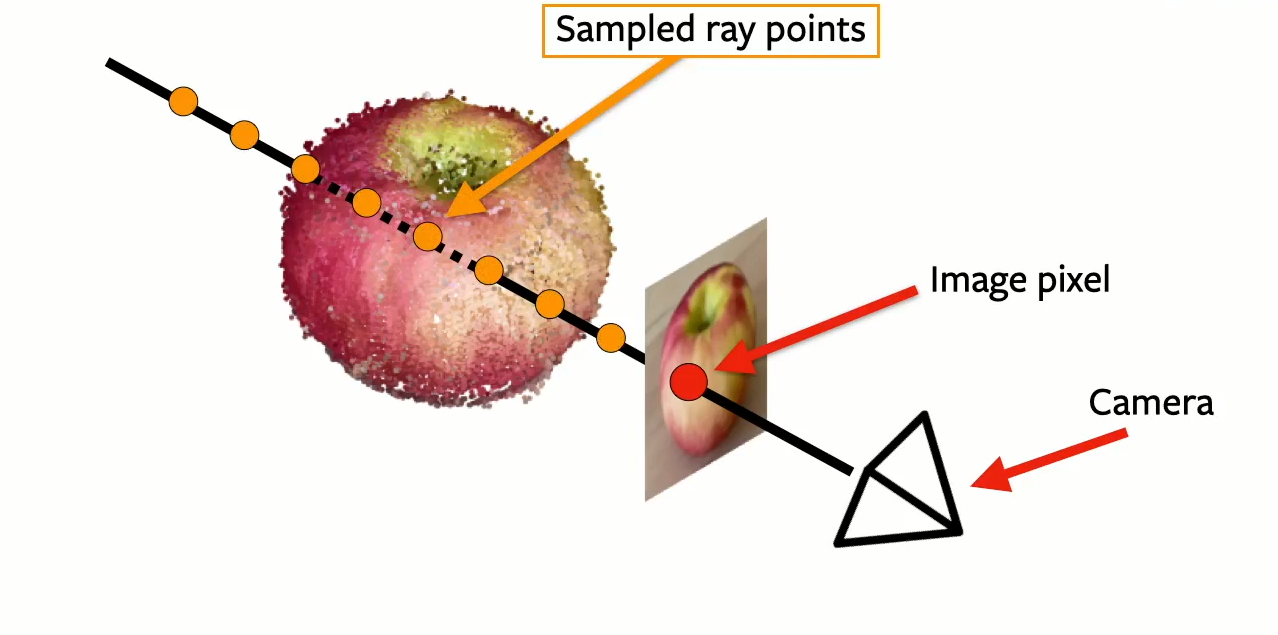

In [130]:
W = 5
H = 4

print(torch.linspace(0, W-1, W)) # 0, 1, 2, 3, 4
print(torch.linspace(0, H-1, H)) # 0, 1, 2, 3
print()
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))

print()
# transpose
i = i.t() # 5 X 4 => 4 X 5
j = j.t() # 5 X 4 => 4 X 5

print(i)
print(j)

grid = torch.stack([i, j], -1)

# 이미지 좌표 표시
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        print(grid[i][j], end=" ")
    print()

tensor([0., 1., 2., 3., 4.])
tensor([0., 1., 2., 3.])


tensor([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]])
tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])
tensor([0., 0.]) tensor([1., 0.]) tensor([2., 0.]) tensor([3., 0.]) tensor([4., 0.]) 
tensor([0., 1.]) tensor([1., 1.]) tensor([2., 1.]) tensor([3., 1.]) tensor([4., 1.]) 
tensor([0., 2.]) tensor([1., 2.]) tensor([2., 2.]) tensor([3., 2.]) tensor([4., 2.]) 
tensor([0., 3.]) tensor([1., 3.]) tensor([2., 3.]) tensor([3., 3.]) tensor([4., 3.]) 


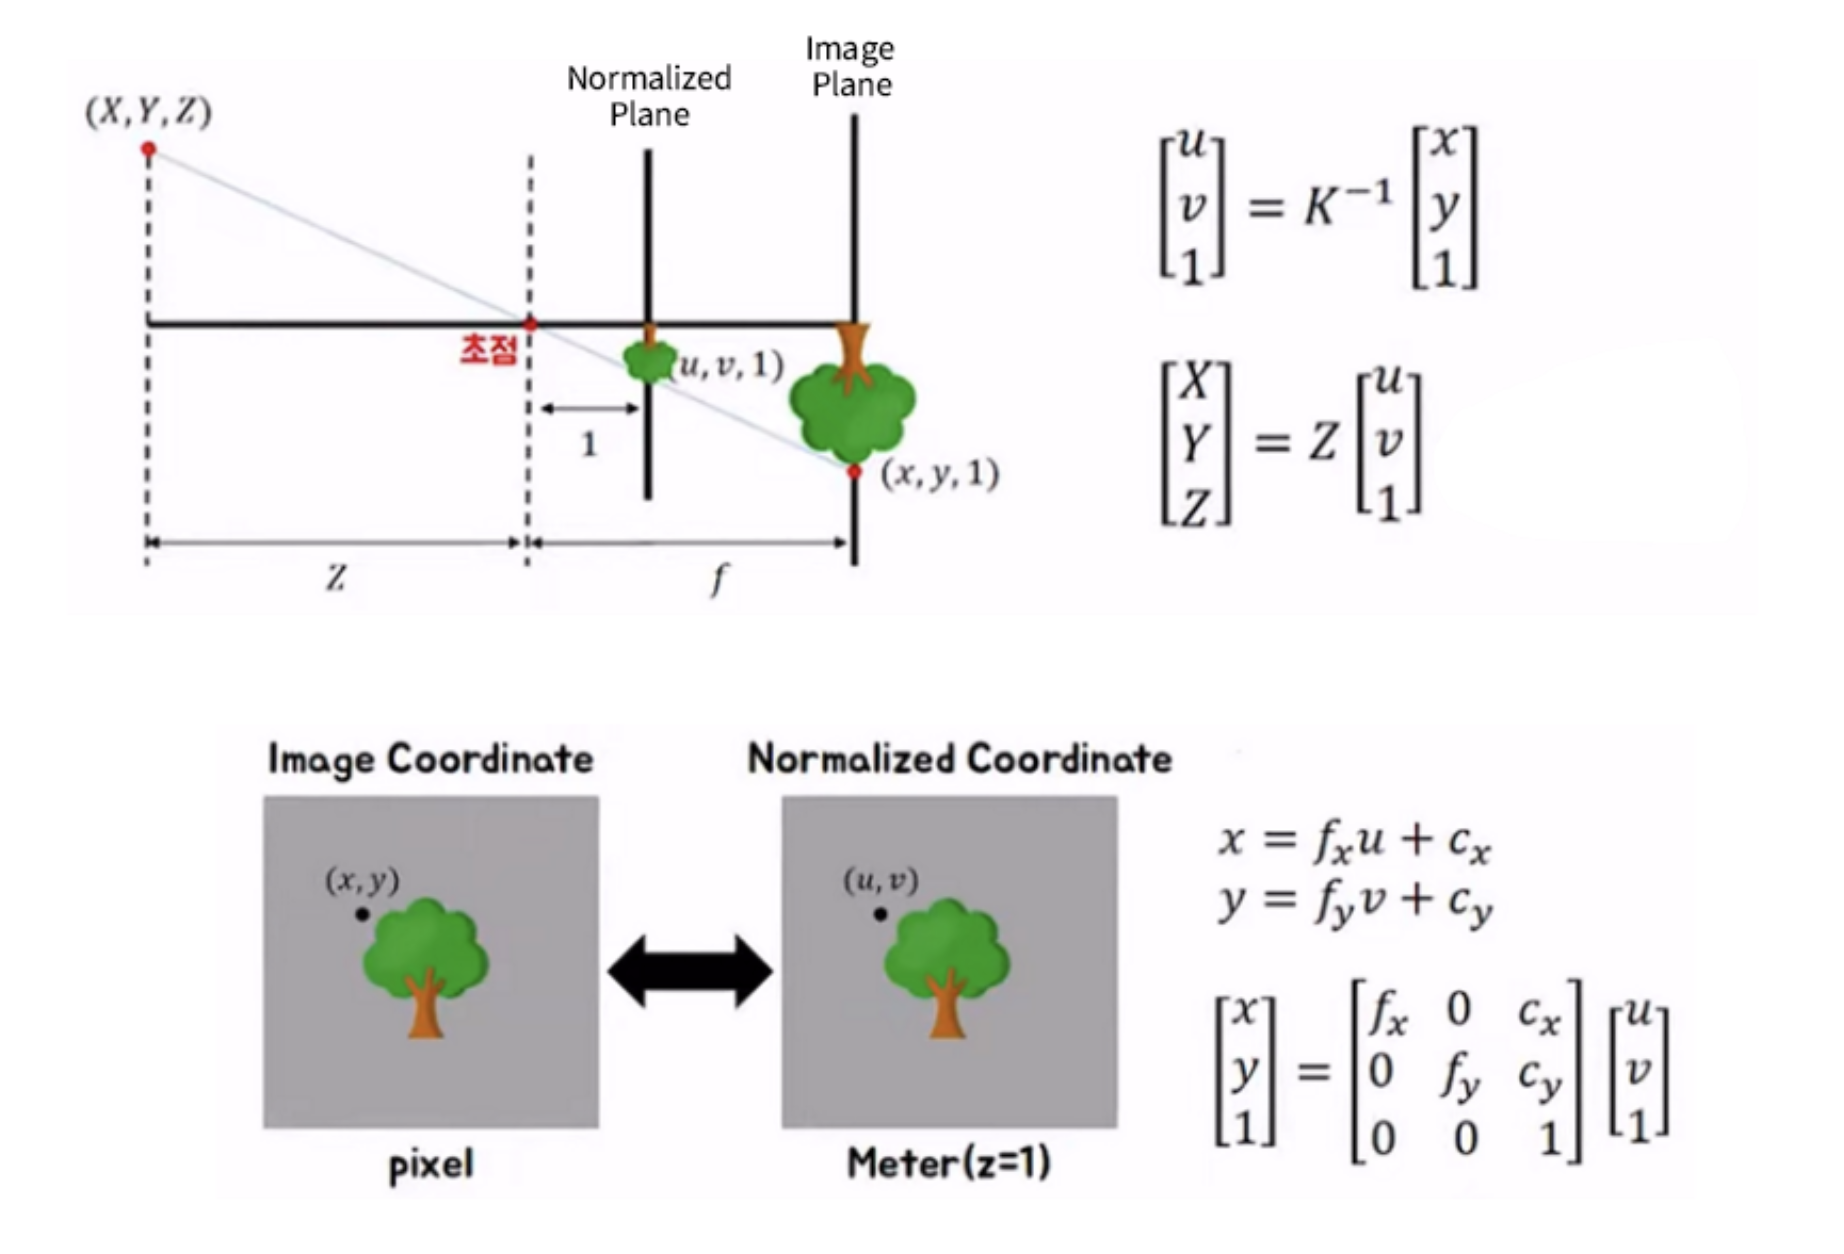

### NDC coordinate

![스크린샷 2022-09-02 오후 10.14.18.png](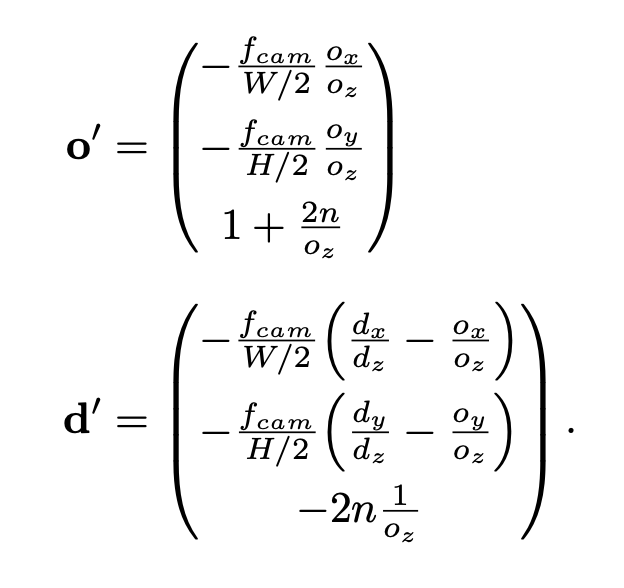 )

---



---



In [131]:
# Ray helpers
def get_rays(H, W, K, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))
    i = i.t()
    j = j.t()
    
    '''
    K = [f, 0, cx]
        [0, f, cy]
        [0, 0,  1]
    '''
    # 각각의 pixel에서 나오는 ray를 생성한다고 볼 수 있음
    dirs = torch.stack([(i - K[0][2])/K[0][0], -(j - K[1][2])/K[1][1], -torch.ones_like(i)], -1) # H, W, 3
    
    # dirs는 camera 좌표계 기준 => world 좌표계로 바꾸어야 함.
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1) # c2w @ dir or c2w.dot(dir)와 동일하지만 이와 같은 표현이 수식적으로 빠름.
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    
    return rays_o, rays_d

In [132]:
def get_rays_np(H, W, K, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, rays_d


## NeRF model 구현

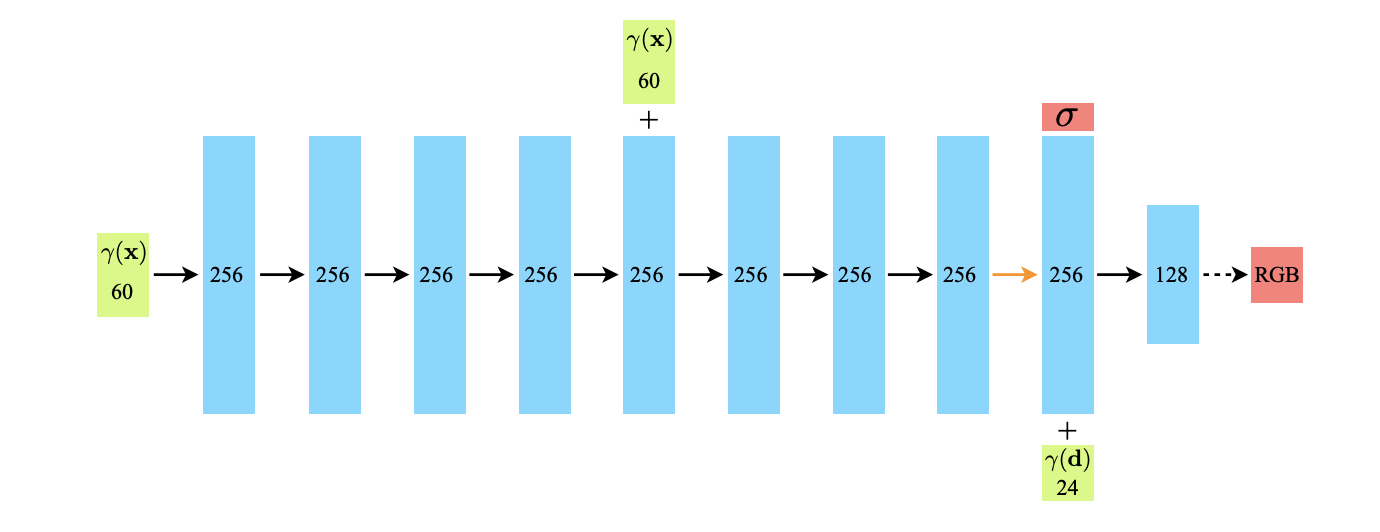

- alpha (volume density)는 view direction과 dependency가 없기 때문에 view direction을 넣기 전에 output을 출력하고, RGB color는 view direction에 dependent하기 때문에 x, d 모두 고려한 출력을 하게 된다.
- x는 positional Encoding을 활용하여 60차원으로 mapping하고, d는 24차원으로 mapping한다.

### Positional Encoding

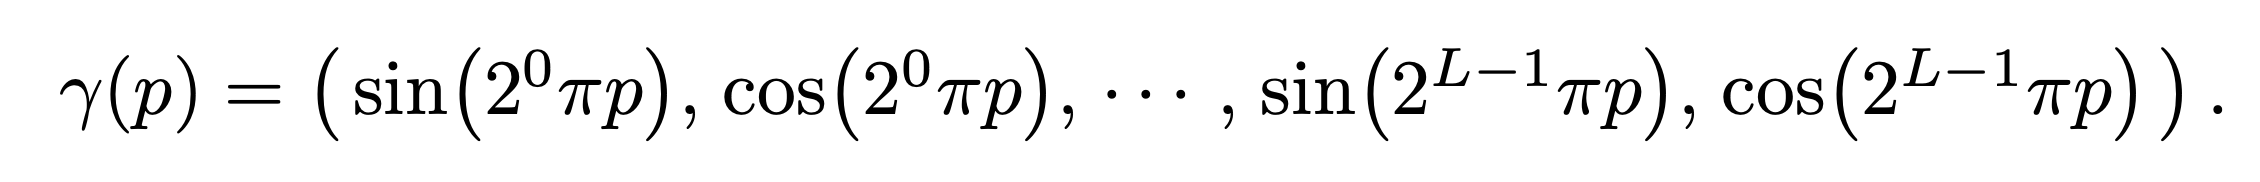

#### Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains

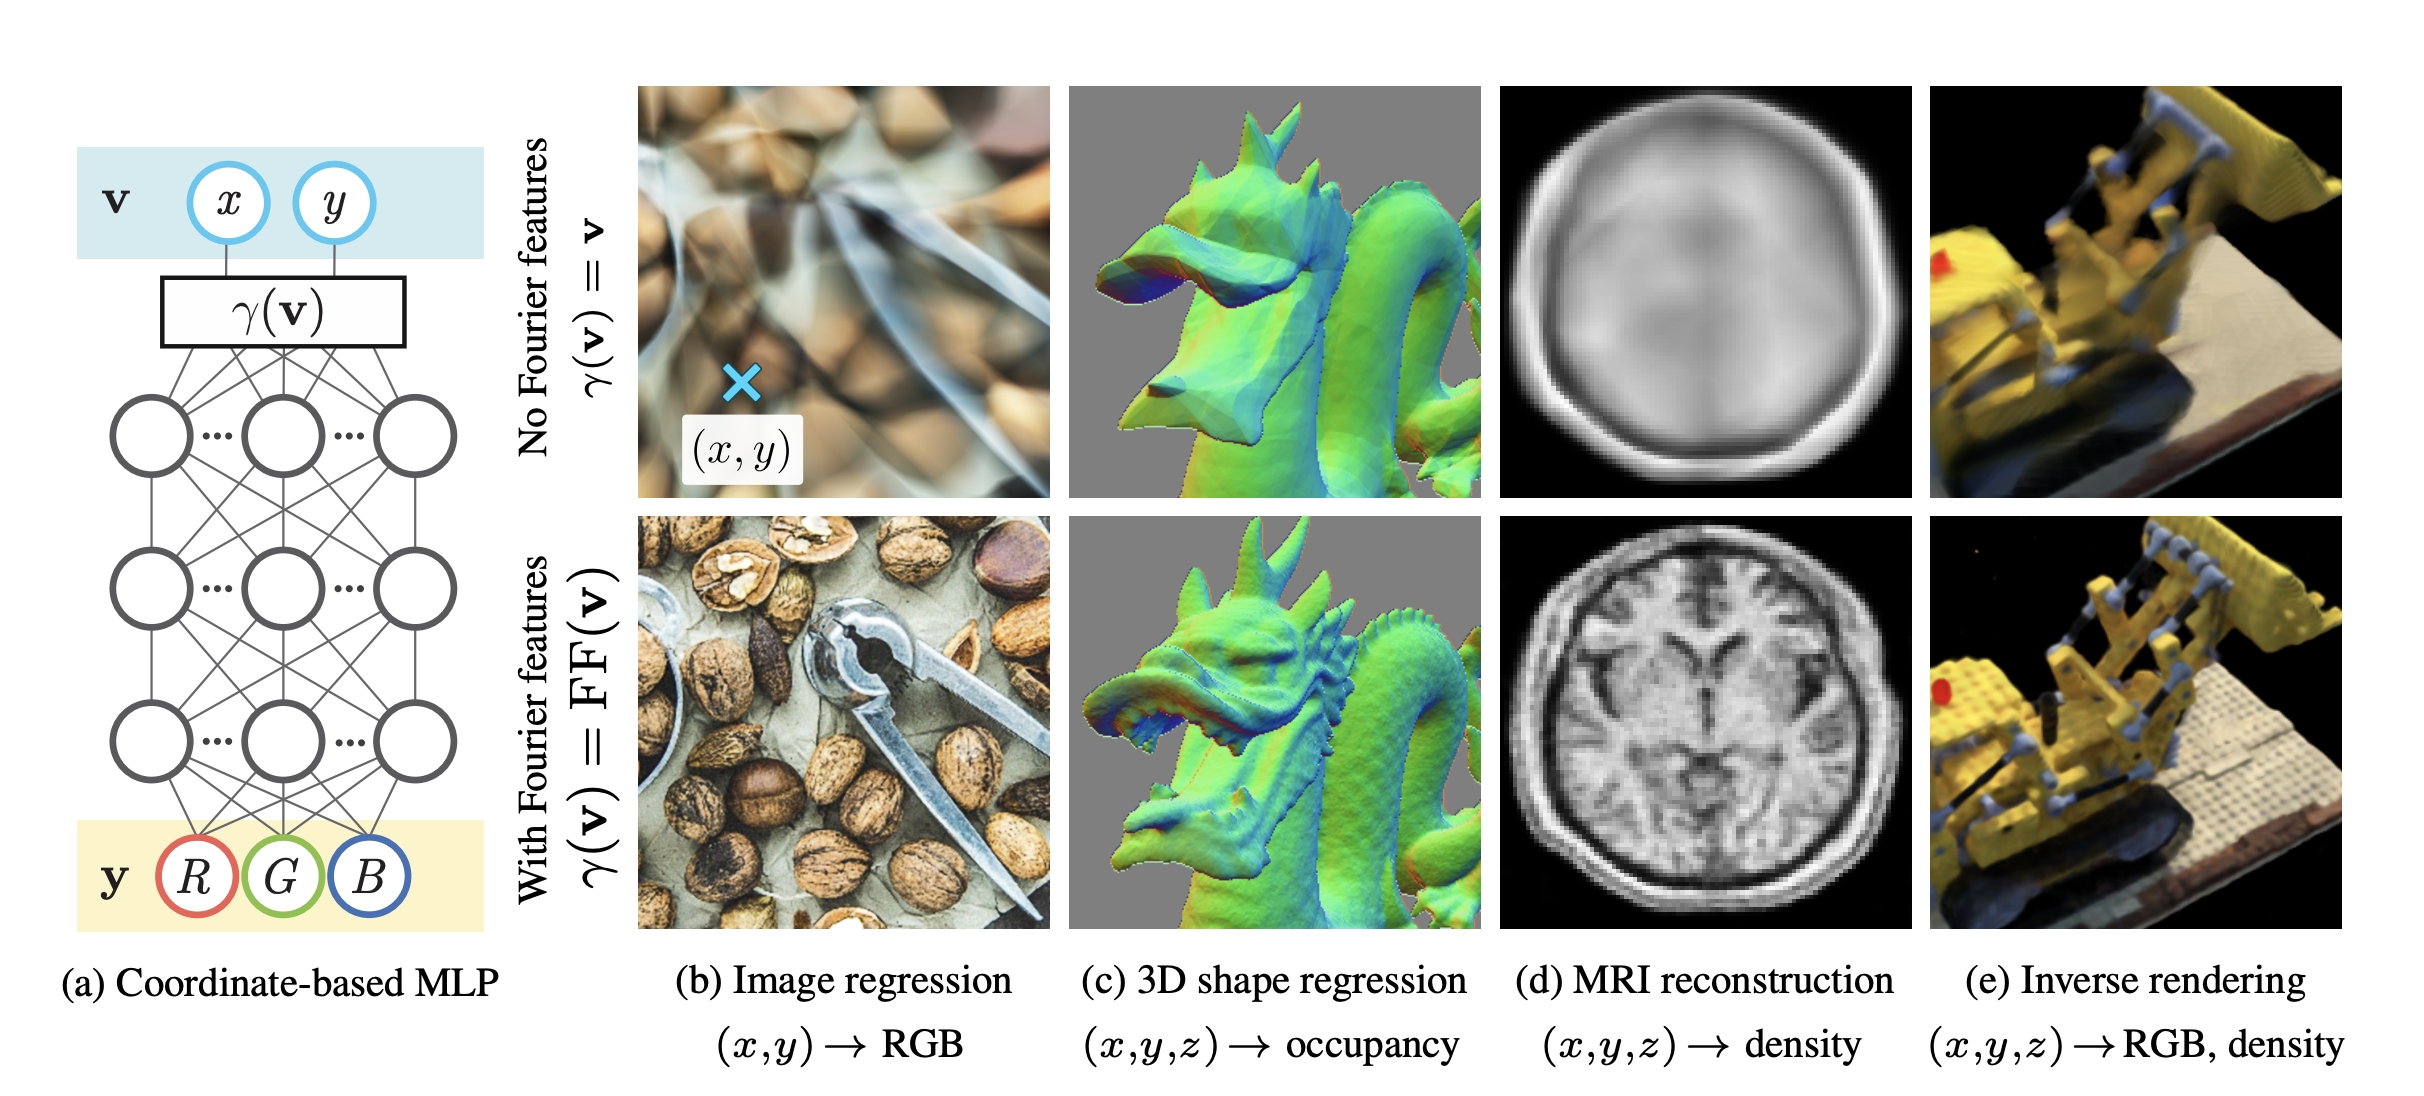

In [141]:
import torch
# torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# Positional Encoding (section 5.1)
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x: x)
            out_dim += d
        
        max_freq = self.kwargs['max_freq_log2'] # L - 1
        N_freqs = self.kwargs['num_freqs'] # Octave = L
        
        # log sampling vs linear sampling
        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0, max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2.**0, 2.**max_freq, step=N_freqs)
            
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d
        
        self.embed_fns = embed_fns
        self.out_dim = out_dim
    
    # add all embeddings in self.embed_fns
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)

def get_embedder(multires, i=0): # m,ultires: Octave
    if i == -1:
        return nn.Identity(), 3
    
    embed_kwargs = {
        'include_input': True,
        'input_dims': 3,
        'max_freq_log2' : multires - 1,
        'num_freqs': multires,
        'log_sampling': True,
        'periodic_fns': [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim


In [142]:
# example
embed, out_dim = get_embedder(10, 0)
print(embed, out_dim) # 3 * 60 + 3 (include_input)

input = torch.zeros(3)
output = embed(input)

print(input.shape)
print(output.shape)
print(output)

embed, out_dim = get_embedder(4)
print(embed, out_dim)

output = embed(input)
print(output)


<function get_embedder.<locals>.<lambda> at 0x7f3e4c286af0> 63
torch.Size([3])
torch.Size([63])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1.])
<function get_embedder.<locals>.<lambda> at 0x7f3e4c396e50> 27
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1.])


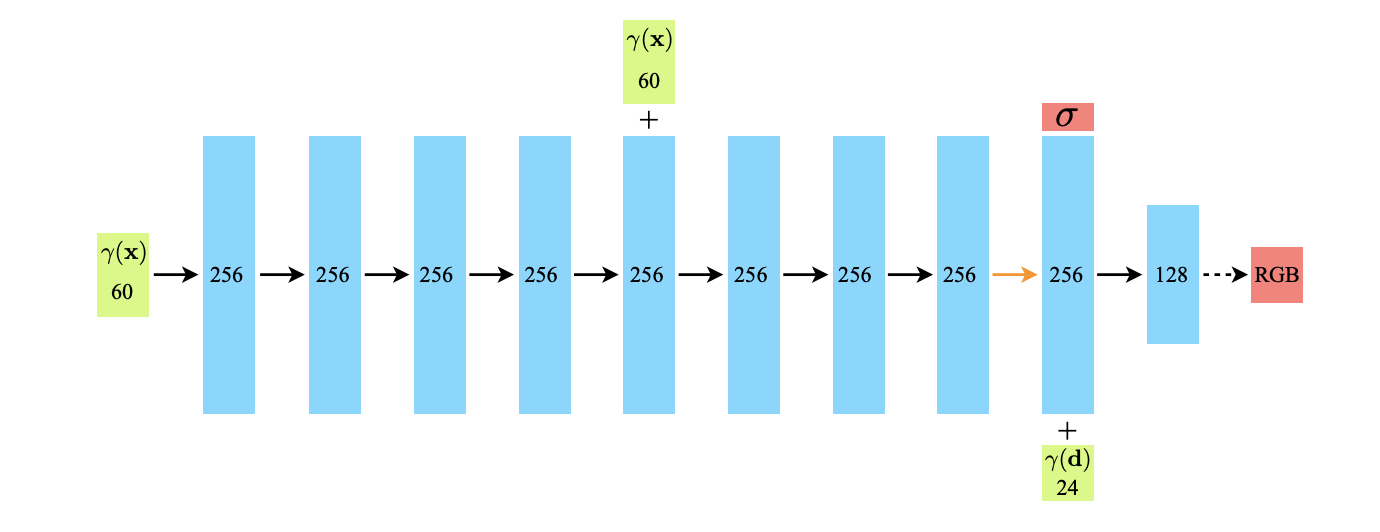

In [143]:
import torch
# torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



# Positional encoding (section 5.1)
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x : x)
            out_dim += d

        max_freq = self.kwargs['max_freq_log2'] # L-1
        N_freqs = self.kwargs['num_freqs'] # Octave = L

        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linpsace(2.**0, 2.**max_freq, step=N_freqs)
        
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)


def get_embedder(multires, i=0):
    if i == -1:
        return nn.Identity(), 3
    
    embed_kwargs = {
                'include_input' : True,
                'input_dims' : 3,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim


# Model
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False):
        """ 
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs
        
        self.pts_linears = nn.ModuleList([nn.Linear(input_ch, W)] + [nn.Linear(W, W) if i not in self.skips else nn.Linear(W+input_ch, W) for i in range(D-1)])

        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)])

        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1)
            self.rgb_linear = nn.Linear(W//2,3)
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1) # (B, 63) , (B, 27)
        h = input_pts
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([input_pts, h], -1) # (B, 63+256)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)
            
            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h)
        
        return outputs    



### sanity check

In [144]:
input = torch.rand(1, 3) # (Batch, input channels : 3)
input_dir = torch.rand(1, 3)

# Positional Encoding
embed, out_dim = get_embedder(10)
embed_dir, out_dim_dir = get_embedder(4)

# Model init
model = NeRF(input_ch=out_dim, input_ch_views=out_dim_dir, use_viewdirs=True)

embed_input = embed(input)
embed_input_dir = embed_dir(input_dir)
print(embed_input.shape, embed_input_dir.shape)

x = torch.cat([embed_input, embed_input_dir], dim=-1)
output = model(x)

print(output)
print(output.shape)

torch.Size([1, 63]) torch.Size([1, 27])
tensor([[ 0.0393, -0.0220, -0.0412,  0.0930]], grad_fn=<CatBackward0>)
torch.Size([1, 4])


In [145]:
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret

Similar to NumPy you can insert a singleton dimension ("unsqueeze" a dimension) by indexing this dimension with None. In turn n[:, None] will have the effect of inserting a new dimension on dim=1. This is equivalent to 
```python
n[:, None] # is equivalent to
n.unsqueeze(dim=1)
```

In [146]:
def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'.
    """
    # inputs: [N_rays, N_samples, 3]
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]])
    embedded = embed_fn(inputs_flat)

    if viewdirs is not None:
        # viewdirs [N_rays, 3]
        input_dirs = viewdirs[:, None].expand(inputs.shape)   # [N_rays, N_samples, 3]
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]]) # [N_rays * N_samples, 3] 512*512*64
        embedded_dirs = embed_fn(input_dirs_flat)
        embedded = torch.cat([embedded, embedded_dirs], -1)

    outputs_flat = batchify(fn, netchunk)(embedded) # run network
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]]) # [N_rays, N_samples, output_ch=4]
    return outputs

In [147]:
def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    embed_fn, input_ch = get_embedder(args.multires, args.i_embed) # 10, 0

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)
    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    model = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if args.N_importance > 0:
        model_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                 embed_fn=embed_fn,
                                                                 embeddirs_fn=embeddirs_fn,
                                                                 netchunk=args.netchunk)

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])

    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine' : model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer

### Volume Rendering

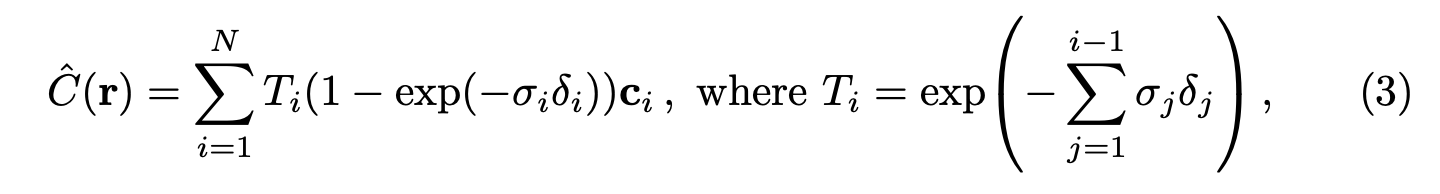


alpha값 : 1 - exp(-density_score * distance) => [0,1]사이의 값을 갖는다.: 해당 지점에 물체가 있는지에 대한 score를 표시하기 위한 값

In [148]:
 def raw2outputs(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False, pytest=False):
    """Transforms model's predictions to semantically meaningful values.
    Args:
        raw: [num_rays, num_samples along ray, 4]. Prediction from model.
        z_vals: [num_rays, num_samples along ray]. Integration time.
        rays_d: [num_rays, 3]. Direction of each ray.
    Returns:
        rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
        disp_map: [num_rays]. Disparity map. Inverse of depth map.
        acc_map: [num_rays]. Sum of weights along each ray.
        weights: [num_rays, num_samples]. Weights assigned to each sampled color.
        depth_map: [num_rays]. Estimated distance to object.
    """
    # raw값에는 -inf ~ inf 범위의 density score가 담겨 있음
    raw2alpha = lambda raw, dists, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*dists)
    
    dists = z_vals[..., 1:] - z_vals[..., :-1] # [num_rays, num_samples - 1]
    dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[..., :1].shape)], -1) # [num_rays, num_samples]
    
    # 예를 들어 대각선으로 나가는 ray의 길이가 더 길기 때문에 이를 normalize 해주어야 한다.
    dists = dists * torch.norm(rays_d[...,None, :], dim=-1)
    
    # rgb -> use sigmoid to make it range 0 ~ 1
    rgb = torch.sigmoid(raw[..., :3]) # shape: num_rays, num_samples, 3
    
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[...,3].shape) * raw_noise_std # option
    
    # alpha값 생성
    alpha = raw2alpha(raw[..., 3] + noise, dists) # noise를 더하면 overfitting을 해소하는데 도움을 줌.
    
    # weights: transmittance * alpha
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)
    rgb_map = torch.sum(weights[..., None] * rgb, -2) # broadcasting, -2 dim denotes num_samples
    # rgb map: weights * rgb
    depth_map = torch.sum(weights * z_vals, -1) # depth map: weights * z_vals, -1 dim denotes num_samples
    disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map), depth_map / torch.sum(weights, -1)) # normalization
    acc_map = torch.sum(weights, -1) # sum of weights of each ray
    # acc_map은 일종의 accupancy map으로 해당 위치의 pixel에 object가 있는지 나타냄.
    
    return rgb_map, disp_map, acc_map, weights, depth_map

In [149]:
sorted_sequence = torch.tensor([[1,3,5,7,9],[2,4,6,8,10]])
values = torch.tensor([[3,6,9], [3,6,9]])


t = torch.tensor([[1,2],[3,4]])
out = torch.gather(t, 1, torch.tensor([[0,0], [1,0]]))
print(out)

tensor([[1, 1],
        [4, 3]])


In [150]:
sorted_sequence = torch.tensor([[1, 3, 5, 7, 9], [2, 4, 6, 8, 10]])
values = torch.tensor([[3, 6, 9], [3, 6, 9]])

torch.searchsorted(sorted_sequence, values, side='left') # side: 같은 숫자가 있을 때, 왼쪽에 넣을지, 오른쪽에 넣을지


test_gather = torch.tensor([[1, 2], [3, 4]])
torch.gather(test_gather, 1, torch.tensor([[1, 0], [1, 0]]))

tensor([[2, 1],
        [4, 3]])

In [151]:
# Hierarchical sampling (section 5.2)
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    # Get pdf
    weights = weights + 1e-5 # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True) # (batch, len(bins)-1)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  # (batch, len(bins))

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples]) # [batch, N_samples] usually N_samples: 128

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(inds-1), inds-1)
    above = torch.min((cdf.shape[-1]-1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], -1)  # (batch, N_samples, 2)

    # cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    # bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]] # (batch, N_samples, len(bins))
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = (cdf_g[...,1]-cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u-cdf_g[...,0])/denom
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0]) # bins_g 0 과 bins_g 1을 t 값으로 

    return samples

In [118]:
def render_rays(ray_batch, 
                network_fn,
                network_query_fn,
                N_samples, # usuall 64
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,  # usually 128
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      retraw: bool. If True, include model's raw, unprocessed predictions.
      lindisp: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_bkgd: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays]. Disparity map. 1 / depth.
      acc_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """
    
    # 0, 1, 2 => rays_o, 3, 4, 5 => rays_d
    # 6, 7 => near, far bound
    # 8, 9, 10 => viewdirs
    
    N_rays = ray_batch.shape[0]
    rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    viewdirs = ray_batch[:,-3:] if ray_batch.shape[-1] > 8 else None
    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2])
    near, far = bounds[...,0], bounds[...,1] # [-1,1]

    t_vals = torch.linspace(0., 1., steps=N_samples)
    if not lindisp:
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples])

    # prevent overfitting
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1]) # sampling mids
        upper = torch.cat([mids, z_vals[..., -1:]], -1)
        lower = torch.cat([z_vals[..., :1], mids], -1) # [N_rays, N_samples]
        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape)

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        z_vals = lower + (upper - lower) * t_rand

    # rays_o : [N_rays, 3], z_vals: [N_rays, N_sample] -> pts: [N_rays, N_sample, 3]
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]

    # raw = run_network(pts)
    raw = network_query_fn(pts, viewdirs, network_fn) # [N_ray, N_samples, 4]
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    # Fine network
    if N_importance > 0:

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        # samples for fine network (saple_pdf: importance sampling)
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        z_samples = z_samples.detach() # usually 128 samples per ray
        
        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1) #[N_rays, N_samples + N_importance] , usually 64 + 128 = 192
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

        run_fn = network_fn if network_fine is None else network_fine
        # raw = run_network(pts, fn=run_fn)
        raw = network_query_fn(pts, viewdirs, run_fn)
        
        # volume rendering
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret


In [119]:
def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)

        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret

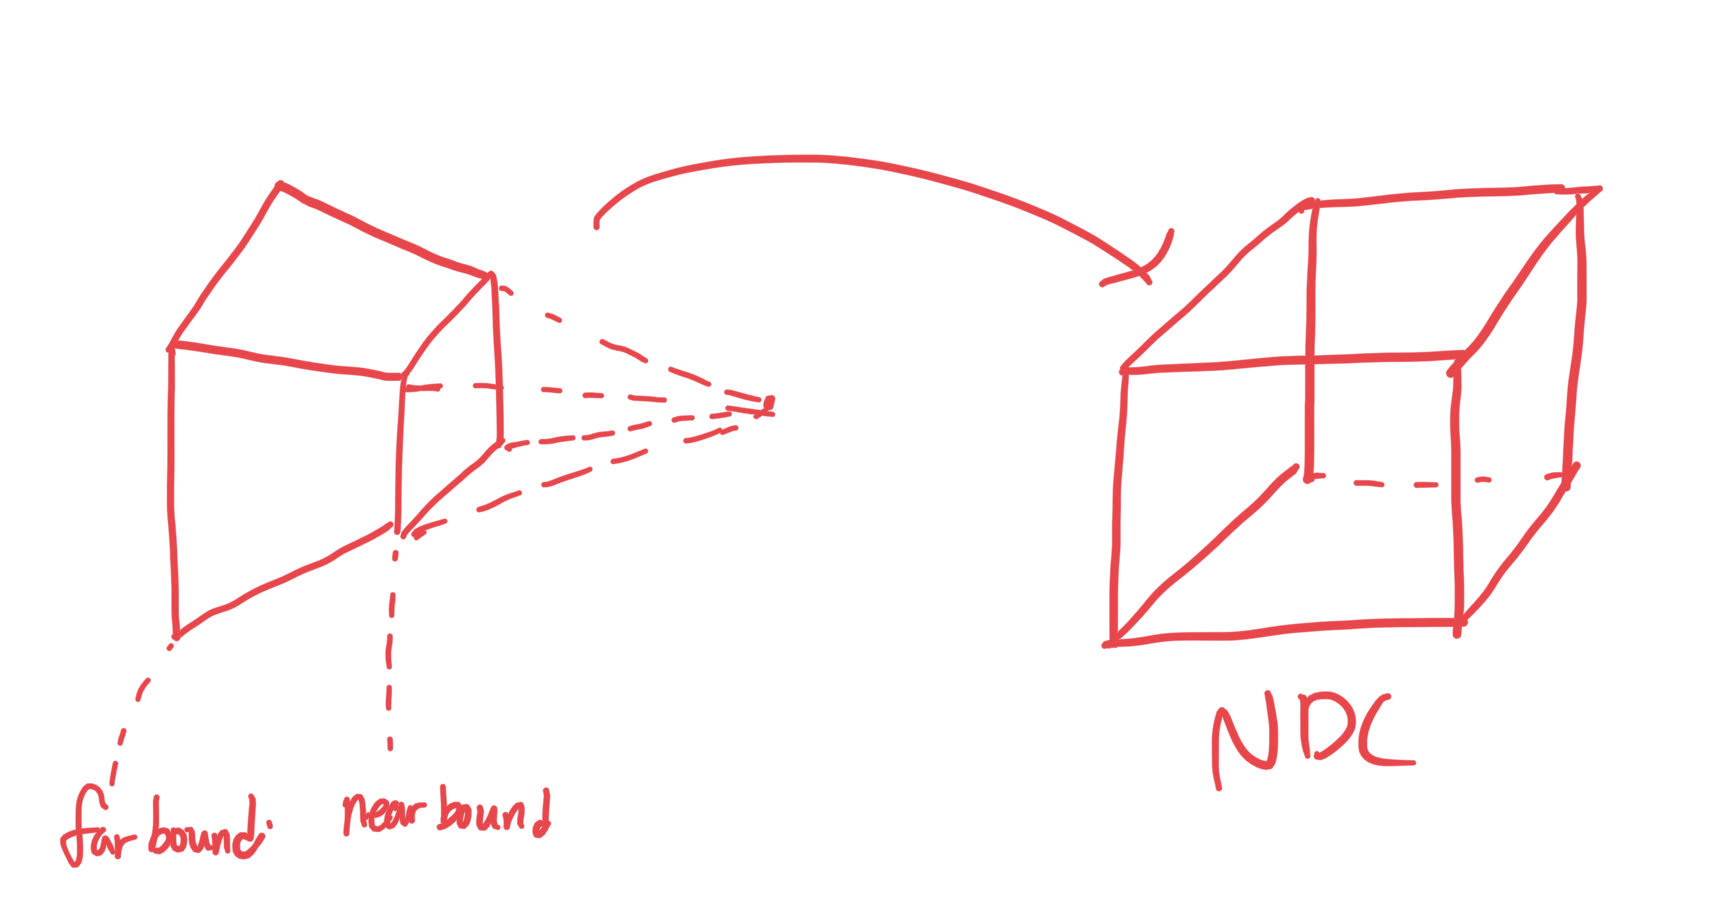

In [124]:
def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
         rays_o, rays_d = get_rays(H, W, K, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()

    sh = rays_d.shape # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)
    
    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far], -1) # (B, 8)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1) # (B, 11)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]

In [125]:
def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        """
        if gt_imgs is not None and render_factor==0:
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_imgs[i])))
            print(p)
        """

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps

## 모델 학습 pipeline 구현

In [126]:
img2mse = lambda x, y : torch.mean((x-y) ** 2)
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)

def train(args):

    # Load data
    K = None
    if args.dataset_type == 'llff':
        images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                  recenter=True, bd_factor=.75,
                                                                  spherify=args.spherify)
        hwf = poses[0,:3,-1]
        poses = poses[:,:3,:4]
        print('Loaded llff', images.shape, render_poses.shape, hwf, args.datadir)
        if not isinstance(i_test, list):
            i_test = [i_test]

        if args.llffhold > 0:
            print('Auto LLFF holdout,', args.llffhold)
            i_test = np.arange(images.shape[0])[::args.llffhold]

        i_val = i_test
        i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                        (i not in i_test and i not in i_val)])

        print('DEFINING BOUNDS')
        if args.no_ndc:
            near = np.ndarray.min(bds) * .9
            far = np.ndarray.max(bds) * 1.
            
        else:
            near = 0.
            far = 1.
        print('NEAR FAR', near, far)

    elif args.dataset_type == 'blender':
        images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
        print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
        i_train, i_val, i_test = i_split

        near = 2.
        far = 6.

        if args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1. - images[...,-1:])
        else:
            images = images[...,:3]

    else:
        print('Unknown dataset type', args.dataset_type, 'exiting')
        return

    # Cast intrinsics to right types
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    # intrinsic matrix
    if K is None:
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])

    if args.render_test:
        render_poses = np.array(poses[i_test])

    # Create log dir and copy the config file
    basedir = args.basedir
    expname = args.expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)
    f = os.path.join(basedir, expname, 'args.txt')
    with open(f, 'w') as file:
        for arg in sorted(vars(args)):
            attr = getattr(args, arg)
            file.write('{} = {}\n'.format(arg, attr))
    if args.config is not None:
        f = os.path.join(basedir, expname, 'config.txt')
        with open(f, 'w') as file:
            file.write(open(args.config, 'r').read())

    # Create nerf model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
    global_step = start

    bds_dict = {
        'near' : near,
        'far' : far,
    }
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    # Move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)

    # Short circuit if only rendering out from trained model
    if args.render_only:
        print('RENDER ONLY')
        with torch.no_grad():
            if args.render_test:
                # render_test switches to test poses
                images = images[i_test]
            else:
                # Default is smoother render_poses path
                images = None

            testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', render_poses.shape)

            rgbs, _ = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test, gt_imgs=images, savedir=testsavedir, render_factor=args.render_factor)
            print('Done rendering', testsavedir)
            imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)

            return

    # Prepare raybatch tensor if batching random rays
    N_rand = args.N_rand
    # batching을 사용하면, 모든 이미지 내에 있는 pixel 안에서 random하게 뽑아서 사용, 사용하지 않으면 이미지 1장 내에서만 사용
    use_batching = not args.no_batching
    if use_batching:
        # For random ray batching
        print('get rays')
        rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [N'*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)

        print('done')
        i_batch = 0

    # Move training data to GPU
    if use_batching:
        images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)

    N_iters = 200000 + 1
    print('Begin')
    print('TRAIN views are', i_train)
    print('TEST views are', i_test)
    print('VAL views are', i_val)

    # Summary writers
    # writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))
    psnrs = []
    iternums = []
    start = start + 1
    for i in trange(start, N_iters):
        time0 = time.time()

        # Sample random ray batch
        if use_batching:
            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0

        else:
            # Random from one image
            img_i = np.random.choice(i_train)
            target = images[img_i]
            target = torch.Tensor(target).to(device)
            pose = poses[img_i, :3,:4]

            if N_rand is not None:

                rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)

                if i < args.precrop_iters:
                    dH = int(H//2 * args.precrop_frac)
                    dW = int(W//2 * args.precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), -1)
                    if i == start:
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
                else:
                    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

                coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
                select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
                select_coords = coords[select_inds].long()  # (N_rand, 2)
                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                batch_rays = torch.stack([rays_o, rays_d], 0) # (2, N_rand, 3)
                target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        #####  Core optimization loop  #####
        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays,
                                                verbose=i < 10, retraw=True,
                                                **render_kwargs_train)

        optimizer.zero_grad()
        img_loss = img2mse(rgb, target_s)
        loss = img_loss
        psnr = mse2psnr(img_loss)

        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)

        loss.backward()
        optimizer.step()

        # NOTE: IMPORTANT!
        ###   update learning rate   ###
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        ################################

        dt = time.time()-time0
        # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")
        #####           end            #####

        # Rest is logging
        if i%args.i_weights==0:
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            torch.save({
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'network_fine_state_dict': render_kwargs_train['network_fine'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, path)
            print('Saved checkpoints at', path)

        if i%args.i_video==0 and i > 0:
            # Turn on testing mode
            with torch.no_grad():
                rgbs, disps = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test)
            print('Done, saving', rgbs.shape, disps.shape)
            moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
            imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)


        if i%args.i_testset==0 and i > 0:
            testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', poses[i_test].shape)
            with torch.no_grad():
                render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, args.chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
            print('Saved test set')


    
        if i%args.i_print==0:
            tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  PSNR: {psnr.item()}")

            testpose = poses[18]
            # Render the holdout view for logging
            with torch.no_grad():
                rgb, depth, acc, _ = render(H, W, K, c2w=testpose[:3,:4], **render_kwargs_test)

            psnrs.append(psnr.detach().cpu().numpy())
            iternums.append(i)
            
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.cpu())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()

        global_step += 1

In [139]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)

/tmp/ipykernel_6970/741859687.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


Loaded blender (138, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/nerf_synthetic/lego
Found ckpts ['./logs/blender_paper_lego/200000.tar']
Not ndc!
Begin
TRAIN views are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
TEST views are [113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137]
VAL views are [100 101 102 103 104 105 106 107 108 109 110 111 112]


  0%|                                                | 0/200000 [00:00<?, ?it/s]

[Config] Center cropping of size 200 x 200 is enabled until iter 500


RuntimeError: split_with_sizes expects split_sizes to sum exactly to 126 (input tensor's size at dimension -1), but got split_sizes=[63, 27]

In [ ]:
#visualize video

args.no_reload=False
args.render_only=True

torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)


In [ ]:
from IPython.display import HTML
from base64 import b64encode
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', 200000))

mp4 = open(os.path.join(testsavedir, 'video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# config for fern

parser = config_parser()
args = parser.parse_args(args=[])
args.config = 'configs/fern.txt'

# load config

with open(args.config, 'r') as fp:
    lines = fp.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split(' = ') for line in lines if len(line)>0]

configs = {}
for line in lines:
    configs[line[0]] = line[1]

print(configs)

args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']

args.factor = int(configs['factor'])
args.llffhold = int(configs['llffhold'])

args.N_rand = int(configs['N_rand'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])


args.use_viewdirs = configs['use_viewdirs']
args.raw_noise_std = float(configs['raw_noise_std'])

args.no_reload = True
print(args)


device = torch.device("cuda")
DEBUG=False
print(device)

## Install COLMAP
https://github.com/colmap/colmap -> Download

-  MAC 사용자의 경우 실행이 안된다면 terminal을 통해 해당 dependency를 깔아줘야함.
```
brew install suite-sparse
```


In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)

In [ ]:
# visualize video
args.no_reload=False
args.render_only=True

torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)


In [ ]:
from IPython.display import HTML
from base64 import b64encode
testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', 200000))

mp4 = open(os.path.join(testsavedir, 'video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)